## OpenAI Gym Warm-Up

In [297]:
# Import Environment class and Libraries
from frozen_lake import FrozenLakeEnv
import numpy as np
import sys
import matplotlib.pyplot as plt
import time


# Create Environment Object
env = FrozenLakeEnv(map_name ="4x4", is_slippery=False)


# Access the number of states:
nS = env.observation_space
print("State space of the Env: ", nS)

# or you could even use 
nS = env.nS
print("State space of the Env by accessing env.nS: ", nS)


# Action space of the agent:
nA = env.nA
print("Action space of the Env: ", nA)

State space of the Env:  16
State space of the Env by accessing env.nS:  16
Action space of the Env:  4


In [298]:
"""
For policy iteration, you would need to access
State(s), Action(a), Next State(ns), Reward(r), episode ended? (is_done) tuples.

Note that in this environment, the orientation of the agent does not matter.
No matter what direction the agent is facing, if, say a left action is performed, 
the agent moves to the left of the crrent state.
"""

# For actions, this is the corresponding dictionary:
action_names = {0:'L', 1:'D', 2:"R", 3:"U"}

"""
Here, 
'L' means left
'D' means down
'R' means right
'U' means up



You can access these tuples by simply env.P[s][a].
where 's' is state, and 'a' is action. For example, let's say we are at state '4',
and we take an action '1' or "Down". The next state (ns) would be 8, the episode would not have ended (is_done), 
the reward (r) is 0 and the transition probabilty (prob) is 1 because this is a deterministic setting.
"""

prob, ns, r, is_done = env.P[4][1][0]

print("Transition Probabilty: ", prob)
print("Next State: ", ns)
print("Reward: ", r)
print("Episode ended? : ", is_done)
# Note that we need to add a [0] after env.P[s][a] because it returns a list containing the tuple

Transition Probabilty:  1.0
Next State:  8
Reward:  0.0
Episode ended? :  False


## Policy Iteration 

- Follow the pseudo-code given in the handout for this section

In [317]:
action_names = {0:'L', 1:'D', 2:"R", 3:"U"}
print(action_names[1])
# policy = np.random.randint(0, 4, size=env.nS)
# print(enumerate(policy))


# # pi = np.zeros(env.nS, dtype=int)
# # print(pi)
# print(pi.reshape([4,-1]))
# pi = np.array([1,2,1,0,1,0,1,0,2,1,1,0,0,2,2,0])
# print(pi.reshape([4,-1]))
# states = 16
# policy_print = np.array([action_names[x] for x in pi])
# print(np.array(policy_print).reshape([-1,4]))

def print_policy(policy, action_names, states):
    """Print the policy in human-readable format.
    If you've implemented this correctly, the output (for 4x4 map) should be:
    
    D R D L 
    D L D L 
    R D D L 
    L R R L 
    
    Parameters
    ----------
    policy: np.ndarray
        Array of state to action number mappings
    action_names: dict
        Mapping of action numbers to characters representing the action.
    num_states: int
        Number of states in the FrozenLakeEnvironment (16 or 64 for 4x4 or 8x8 maps respectively)      
    """
    # WRITE YOUR CODE HERE:
    fig, ax = plt.subplots()
    ax.matshow(policy.reshape([-1,4]), cmap='YlGnBu')
    for (i,j), z in np.ndenumerate(policy.reshape([-1,4])):
        ax.text(j, i, action_names[z], ha='center',va='center')
    plt.show()
#     pi_read = np.array([action_names[x] for x in policy])
#     print(np.array(pi_read).reshape([-1,4]))
#     pass
        

D


In [300]:
def one_step_lookahead(env, state, value_func, gamma):
    """
    Helps calculate the value for all action in a given state.

    Parameters
    ----------
    env: Frozen Lake Environment
      The environment to comput value iteration for.
    state: int
      The state to consider.
    value_func: np.array
      The value function to use as an estimator.
    gamma: float
      Discount factor, must be in range [0, 1)

    Returns
    -------
    A: np.array
      A vector of length env.nA containing the expected value of 
      each iteration
    """
#     A = np.zeros(env.nA)
#     val = 0
#     for a in range(env.nA):
#         for prob, next_state, reward, done in env.model[state][a]:
#             val += prob *(reward + gamma*value_func[next_state])
#         A[a] = val
    action_values = []
    state_value = 0
    for action in range(env.nA):
        for i in range(len(env.P[state][action])):
            prob, next_state, reward, done = env.P[state][action][i]
            state_action_value = prob * reward + (gamma*value_func[next_state])
            state_value += state_action_value
        action_values.append(state_value)
            
    return np.asarray(action_values)

def q_value(env, s, value_func, gamma):
    q = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[s][a]:
            q[a] += prob*(reward + gamma * value_func[next_state])
    return q

# Q = np.zeros([env.nA, env.sA])
# for s in range(env.nS):
#     Q[s] = q_value(env, V, s)
# print(Q)

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
[1.       1.99     2.9701   6.880798 1.       1.       2.98     1.
 1.       2.98     1.       1.       1.       1.99     2.9701   1.      ]
16


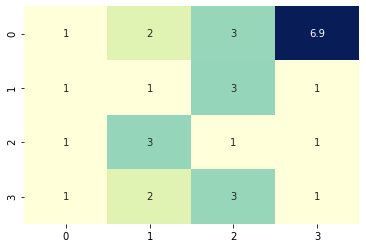

In [306]:
def evaluate_policy_sync(env, gamma, policy, value_func, max_iterations=int(1e3), tol=1e-3):
    """Performs policy evaluation.
    
    Evaluates the value of a given policy.

    Parameters
    ----------
    env: Frozen Lake Environment
      The environment to compute value iteration for.
    gamma: float
      Discount factor, must be in range [0, 1)
    policy: np.array
      The policy to evaluate. Maps states to actions.
    value_func: np.array
      Array of scalar values for each state
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    np.ndarray, int
      The value for the given policy and the number of iterations till
      the value function converged.
    """
    val_iter=0
    new_value_func = np.zeros(env.nS)
    for val_iter in range(max_iterations): 
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            Vs = 1
            for a, action_prob in enumerate([policy[s]]):
                for prob, next_state, reward, done in env.P[s][a]:
                    if next_state == s:
                        Vs += reward
                    else:
                        Vs += action_prob * prob * (reward + gamma * value_func[next_state])
            delta = max(delta, np.abs(value_func[s] - Vs))
            value_func[s] = Vs
        if delta < tol:
            break
    return value_func, val_iter
    
#     val_iter=0
#     new_value_func = np.zeros(env.nS)
#     for val_iter in range(max_iterations): 
#         delta = 0
#         # For each state, perform a "full backup"
#         for s in range(env.nS):
#             old_value = value_func
#             a = policy[s]
#             for prob, next_state, reward, done in env.P[s][a]:
#                 if next_state == s:
#                     new_value_func[s] = reward
#                 else:
#                     new_value_func[s] = action_prob * prob * (reward + gamma * value_func[next_state])
#             delta = np.abs(old_value - new_value_func)
#         if np.all(delta < tol):
#             break
#     return new_value_func, val_iter

env = FrozenLakeEnv(map_name ="4x4", is_slippery=False)
env.reset()
action = 1
(observation, reward, done, prob) = env.step(action)
env.render()
action = 1
(observation, reward, done, prob) = env.step(action)
env.render()
action = 1
(observation, reward, done, prob) = env.step(action)
env.render()


# Checking #
policy = np.random.randint(0, 4, size=env.nS)
value_func = np.zeros(env.nS)
gamma = 0.99
V, val_iter = evaluate_policy_sync(env, gamma, policy, value_func)
print(V)
import seaborn as sns
plt.figure()
sns.heatmap(V.reshape(4,4), cmap='YlGnBu', annot=True, cbar=False)
S_n = env.observation_space
A_n = env.action_space
print(S_n)




In [302]:
def improve_policy(env, gamma, value_func, policy):
    """Performs policy improvement.
    
    Given a policy and value function, improves the policy.

    Parameters
    ----------
    env: Frozen Lake Environment
      The environment to compute value iteration for.
    gamma: float
      Discount factor, must be in range [0, 1)
    value_func: np.ndarray
      Value function for the given policy.
    policy: dict or np.array
      The policy to improve. Maps states to actions.

    Returns
    -------
    bool, np.ndarray
      Returns the new imporved policy.
    """
    for s in range(env.nS):
        old_action = policy[s]
        action_values = q_value(env, s, value_func, gamma)
        policy[s] = np.argmax(action_values)
        
    return policy

#     return new_policy

In [303]:
import copy
def policy_iteration_sync(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """Runs policy iteration.

    See page 85 of the Sutton & Barto Second Edition book.

    You should call the improve_policy() and evaluate_policy_sync() methods to
    implement this method.
    
    If you've implemented this correctly, it should take much less than 1 second.
    
    Parameters
    ----------
    env: Frozen Lake Environment
      The environment to compute value iteration for.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    (np.ndarray, np.ndarray, int, int)
       Returns optimal policy, value function, number of policy
       improvement iterations, and number of value iterations.
    """
    
    policy = np.random.randint(0, 4, size=env.nS)   #Define random policy
    value_func = np.zeros(env.nS)    # Define initial value function
    num_pol_iter = 0
    num_val_iter = 0
    value_iter_list = []
    for i in range(max_iterations):
        value_func, val_iter = evaluate_policy_sync(env, gamma, policy, value_func)
        num_val_iter += val_iter
        value_iter_list.append(value_func)
        new_policy = improve_policy(env, gamma, value_func, policy)
        num_pol_iter +=1
        policy=new_policy.copy()
        delta = policy-new_policy
        if delta.all() < tol:
            break
        
        

    return policy, value_func, num_pol_iter, num_val_iter, value_iter_list

The running time for value iterations is  0.0008482933044433594  seconds
1
1


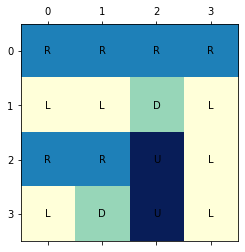

[[ 1.        1.99      6.9103   21.523591]
 [ 1.        1.        3.97      1.      ]
 [ 1.        1.99      6.9103    1.      ]
 [ 1.        2.98      1.        1.      ]]


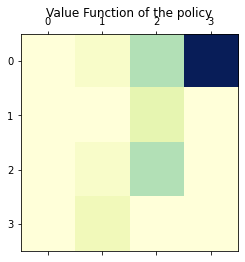

In [318]:
# from plot_utils import plot_values
def main():
    
    # WRITE YOUR CODE HERE:
    env = FrozenLakeEnv(map_name ="4x4", is_slippery=False)
    gamma = 0.99
    startTime = time.time()
    policy, value_func, num_pol_iter, num_val_iter, value_iter_list = policy_iteration_sync(env, gamma)
    
    endTime = time.time()
    print("The running time for value iterations is ", endTime-startTime, ' seconds')
    print(num_pol_iter)
    print(num_val_iter)
    action_names = {0:'L', 1:'D', 2:"R", 3:"U"}
    print_policy(policy, action_names, env.nS)
    print(value_func.reshape([-1,4]))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title('Value Function of the policy')
    ax.matshow(value_func.reshape([-1,4]), cmap='YlGnBu')
    
#     plot_values(value_func)
    
#     env.render()
#     obs, reward, done, _ = env.step(policy[env.s])
#     while done is False:
#         env.render()
#         obs, reward, done, _, env.step(policy[obs])
#     env.render()
# Plot a graph showing the value function of all states as a function of number of policy iterations
# for 4 by 4 maps.  


    
if __name__ == "__main__":
    main()